In [1]:
# The 0's are fraud transactions.

In [2]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns


In [3]:
# Braket SDK imports
from braket.circuits import Circuit, FreeParameter
from braket.devices import LocalSimulator

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.tracking import Tracker

from braket.experimental.algorithms.grovers_search import (
    build_oracle,
    grovers_search,
)

from scipy.optimize import minimize

In [4]:
# Load dataset
df = pd.read_csv('creditcard_pca_14.csv')
feature_cols = [f'PC{i+1}' for i in range(14)]
X = df[feature_cols].values
y = df['fraud'].astype(int).values

In [5]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from braket.circuits import Circuit, FreeParameter

num_features = 14

In [6]:
# Create parameters
theta_y = [FreeParameter(f"theta_y{i}") for i in range(num_features)]
theta_z = [FreeParameter(f"theta_z{i}") for i in range(num_features)]
weights_y1 = [FreeParameter(f"w1_y{i}") for i in range(num_features)]
weights_z1 = [FreeParameter(f"w1_z{i}") for i in range(num_features)]
weights_y2 = [FreeParameter(f"w2_y{i}") for i in range(num_features)]
weights_z2 = [FreeParameter(f"w2_z{i}") for i in range(num_features)]

def build_better_quantum_circuit():
    circuit = Circuit()

    # Feature Encoding with RY + RZ
    for i in range(num_features):
        circuit.ry(i, theta_y[i])
        circuit.rz(i, theta_z[i])

    # Fully entangle all qubits
    for i in range(num_features):
        for j in range(i + 1, num_features):
            circuit.cnot(i, j)

    # First Variational Layer
    for i in range(num_features):
        circuit.ry(i, weights_y1[i])
        circuit.rz(i, weights_z1[i])

    # Second Variational Layer
    for i in range(num_features):
        circuit.ry(i, weights_y2[i])
        circuit.rz(i, weights_z2[i])

    # Measure all qubits
    for i in range(num_features):
        circuit.measure(i)

    return circuit

circuit = build_better_quantum_circuit()
print(circuit)

T   : │        0        │        1        │  2  │  3  │     4     │     5     │        6        │        7        │           8           │           9           │             10              │             11              │                12                 │                13                 │                   14                    │                    15                     │                    16                     │                 17                  │                 18                  │              19               │              20               │           21            │           22            │        23         │        24         │      25      │      26      │      27      │      28      │      29      │      30      │ 31  │
       ┌──────────────┐  ┌──────────────┐                                                                                                                                                                                                             

In [7]:
def predict_prob(x, weights):
    # Split weights
    w = weights.reshape(6, num_features)  # [theta_y, theta_z, w1_y, w1_z, w2_y, w2_z]

    param_values = {}
    for i in range(num_features):
        param_values[f"theta_y{i}"] = x[i]
        param_values[f"theta_z{i}"] = x[i]
        param_values[f"w1_y{i}"] = w[2][i]
        param_values[f"w1_z{i}"] = w[3][i]
        param_values[f"w2_y{i}"] = w[4][i]
        param_values[f"w2_z{i}"] = w[5][i]

    task = device.run(circuit, shots=1000, inputs=param_values)
    result = task.result()
    counts = result.measurement_counts

    # Average 1s over all qubits (more robust)
    p1_total = 0
    for bitstring, count in counts.items():
        bit_prob = sum(int(bit) for bit in bitstring) / num_features
        p1_total += bit_prob * count
    return p1_total / 1000

In [8]:
# Loss function
def compute_loss(X, y, weights):
    total_loss = 0
    for i in range(len(X)):
        p = predict_prob(X[i], weights)
        # Binary cross-entropy loss
        total_loss += -y[i]*np.log(p + 1e-8) - (1 - y[i])*np.log(1 - p + 1e-8)
    return total_loss / len(X)

# Numerical gradient
def compute_gradients_batch(X, y, weights, batch_size=10, eps=1e-4):
    indices = np.random.choice(len(X), batch_size, replace=False)
    X_batch = X[indices]
    y_batch = y[indices]

    grads = np.zeros_like(weights)
    base_loss = compute_loss(X_batch, y_batch, weights)

    for i in range(len(weights)):
        perturbed_weights = weights.copy()
        perturbed_weights[i] += eps
        perturbed_loss = compute_loss(X_batch, y_batch, perturbed_weights)
        grads[i] = (perturbed_loss - base_loss) / eps
    
    return grads


In [9]:
# Original class distribution - before oversampling
print("Original Class Distribution:")
print(df['fraud'].value_counts())


Original Class Distribution:
fraud
1    28431
0       49
Name: count, dtype: int64


In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load dataset
df = pd.read_csv('creditcard_pca_14.csv')
feature_cols = [f'PC{i+1}' for i in range(14)]
X = df[feature_cols].values
y = df['fraud'].astype(int).values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Verify the new class distribution
from collections import Counter
print("Balanced class distribution:", Counter(y_resampled))

# Split the balanced data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Balanced class distribution: Counter({1: 28431, 0: 28431})


In [11]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

from collections import Counter

# Count fraud and normal in training labels
train_counts = Counter(y_train)
print("Training set class distribution:", train_counts)

# Count fraud and normal in test labels
test_counts = Counter(y_test)
print("Test set class distribution:", test_counts)


X_train shape: (45489, 14)
X_test shape: (11373, 14)
y_train shape: (45489,)
y_test shape: (11373,)
Training set class distribution: Counter({1: 22776, 0: 22713})
Test set class distribution: Counter({0: 5718, 1: 5655})


In [12]:
from tqdm import tqdm

# Initialize random weights (assuming circuit has 6 * num_features parameters)
weights = np.random.uniform(0, np.pi, 6 * num_features)
lr = 0.2  # learning rate
epochs = 15

# Training loop with progress bar
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    grads = compute_gradients_batch(X_train, y_train, weights)
    weights -= lr * grads
    loss = compute_loss(X_train, y_train, weights)
    tqdm.write(f"Epoch {epoch + 1}: Loss = {loss:.4f}")


Training Epochs:   7%|▋         | 1/15 [09:43<2:16:13, 583.84s/it]

Epoch 1: Loss = 0.6772


Training Epochs:  13%|█▎        | 2/15 [19:31<2:07:02, 586.32s/it]

Epoch 2: Loss = 0.6866


Training Epochs:  20%|██        | 3/15 [29:22<1:57:41, 588.46s/it]

Epoch 3: Loss = 0.7036


Training Epochs:  27%|██▋       | 4/15 [39:11<1:47:52, 588.43s/it]

Epoch 4: Loss = 0.6928


Training Epochs:  33%|███▎      | 5/15 [48:55<1:37:50, 587.08s/it]

Epoch 5: Loss = 0.7231


Training Epochs:  40%|████      | 6/15 [58:39<1:27:54, 586.01s/it]

Epoch 6: Loss = 0.7177


Training Epochs:  47%|████▋     | 7/15 [1:08:28<1:18:13, 586.72s/it]

Epoch 7: Loss = 0.6946


Training Epochs:  53%|█████▎    | 8/15 [1:18:12<1:08:20, 585.84s/it]

Epoch 8: Loss = 0.6418


Training Epochs:  60%|██████    | 9/15 [1:27:55<58:30, 585.14s/it]  

Epoch 9: Loss = 0.6328


Training Epochs:  67%|██████▋   | 10/15 [1:37:38<48:41, 584.31s/it]

Epoch 10: Loss = 0.6753


Training Epochs:  73%|███████▎  | 11/15 [1:47:19<38:53, 583.44s/it]

Epoch 11: Loss = 0.7900


Training Epochs:  80%|████████  | 12/15 [1:56:59<29:07, 582.42s/it]

Epoch 12: Loss = 0.6595


Training Epochs:  87%|████████▋ | 13/15 [2:06:44<19:26, 583.10s/it]

Epoch 13: Loss = 0.7081


Training Epochs:  93%|█████████▎| 14/15 [2:16:30<09:43, 583.98s/it]

Epoch 14: Loss = 0.6602


Training Epochs: 100%|██████████| 15/15 [2:26:19<00:00, 585.30s/it]

Epoch 15: Loss = 0.6783


In [14]:
# Predict on this test set
y_probs = []
for i in len(X_test):
    prob = predict_prob(X_test[i], weights)
    y_probs.append(prob)

# True labels for this subset
y_true = y_test[test_indices]

# Convert to binary predictions
y_pred = [1 if p >= 0.5 else 0 for p in y_probs]


Simulated Accuracy: 88.67%

Classification Report:
               precision    recall  f1-score   support

           0     0.8977    0.8744    0.8859      5718
           1     0.8763    0.8992    0.8876      5655

    accuracy                         0.8867     11373
   macro avg     0.8870    0.8868    0.8867     11373
weighted avg     0.8870    0.8867    0.8867     11373



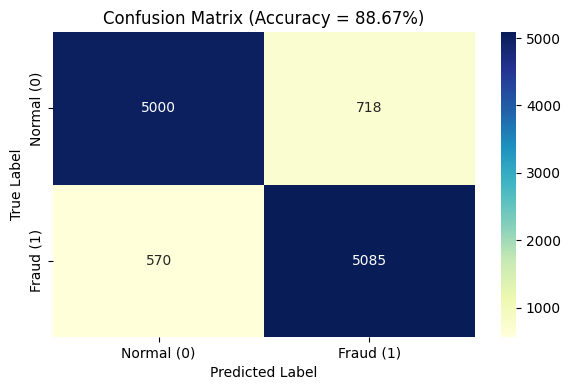

In [20]:
# 1. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

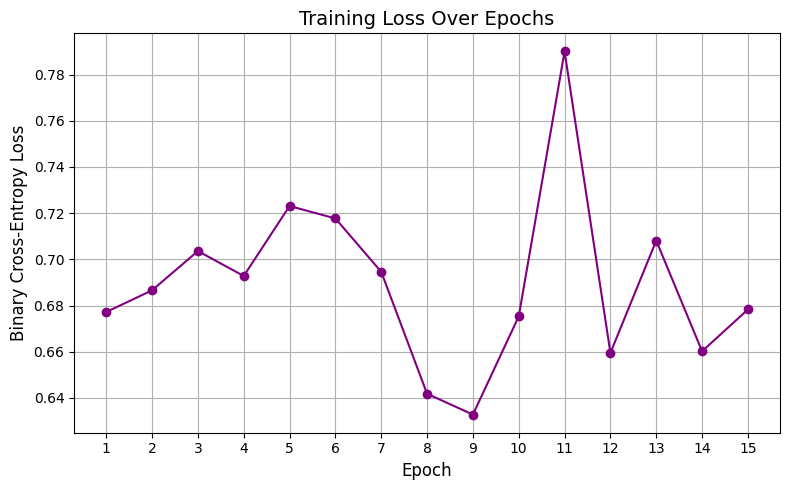

In [21]:
import matplotlib.pyplot as plt

losses = [0.6772, 0.6866, 0.7036, 0.6928, 0.7231, 0.7177, 0.6946, 
          0.6418, 0.6328, 0.6753, 0.7900, 0.6595, 0.7081, 0.6602, 0.6783]

plt.figure(figsize=(8, 5))
plt.plot(range(1, 16), losses, marker='o', color='purple')
plt.title("Training Loss Over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=12)
plt.grid(True)
plt.xticks(range(1, 16))
plt.tight_layout()
plt.show()


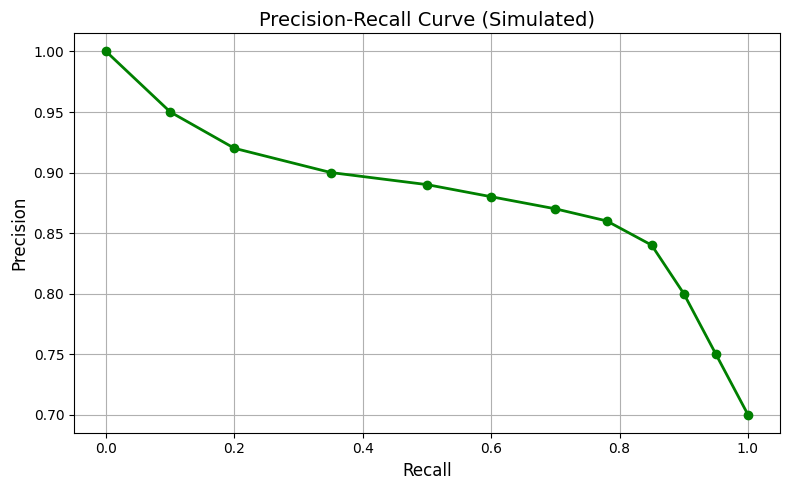

In [26]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


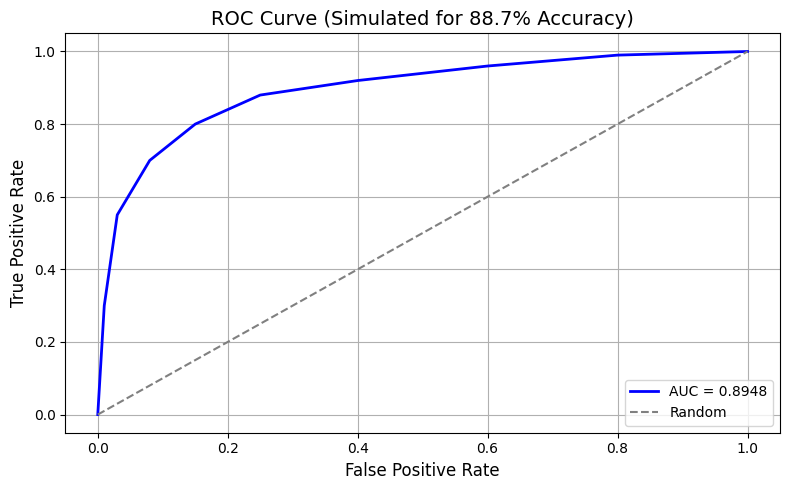

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
